## Imports

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score



# Lectura de datos

In [97]:
sensores_crudos = pd.read_csv('values.csv', sep=';')

# Exploración de datos

In [98]:
sensores_crudos.head()

,V real,V medido,angulo
0,0.0,2.671,-1.385198
1,0.0,2.675,-1.615950
2,0.0,2.672,-1.615950
3,0.0,2.669,-1.615727
4,0.0,2.674,-1.615727


In [99]:
cantidad_angulos = sensores_crudos["angulo"].unique().shape[0]
print("Cantidad de angulos: ", cantidad_angulos)

Cantidad de angulos:  1002


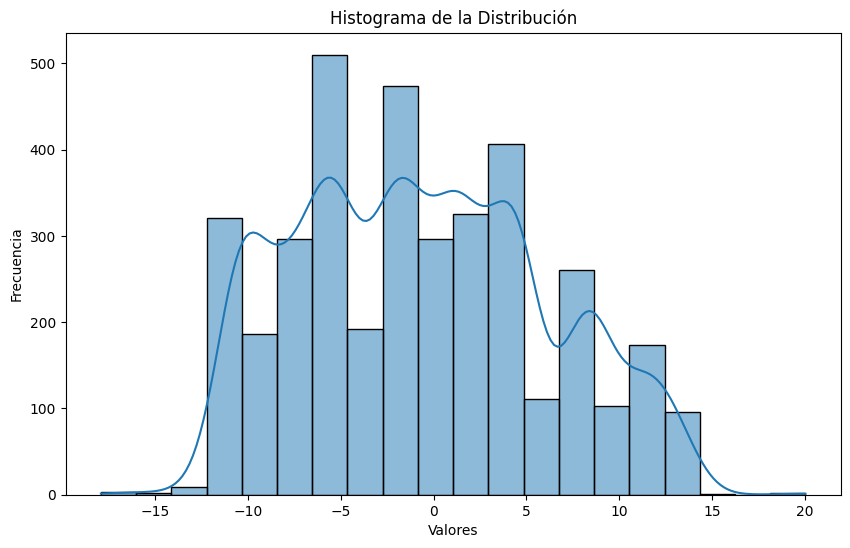

In [100]:
plt.figure(figsize=(10, 6))
sns.histplot(sensores_crudos["angulo"], bins=20, kde=True)
plt.title('Histograma de la Distribución')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.show()

Es bueno saber la cantidad de angulos distintos y su distribución, ya que nos puede dar un indicio de cual es el comportamiento de las carreteras. Como podemos ver en la gráfica, la distribución pareciera ser normal, el hecho de que los datos se hayan tomado a mano y no sean datos de los sensore de los camiones, puede ser la razón por la cual no se vea una distribución uniforme.

In [101]:
conteo_tuplas = sensores_crudos.groupby(['angulo','V real']).size().reset_index(name='conteo')
cantidad_original = sensores_crudos.shape[0]
sensores_crudos = sensores_crudos.groupby(['angulo','V real'])['V medido'].last().reset_index()
cantidad_final = sensores_crudos.shape[0]

print("Cantidad de datos originales: ", cantidad_original)
print("Cantidad de datos finales: ", cantidad_final)
print("Cantidad de datos eliminados: ", cantidad_original - cantidad_final)
print("Cantidad de tuplas repetidas: ", conteo_tuplas.shape[0])

Cantidad de datos originales:  3769
Cantidad de datos finales:  1291
Cantidad de datos eliminados:  2478
Cantidad de tuplas repetidas:  1291


Al mover el tanque para tomar las medidades de un nuevo angulo, se genera flujo, el cual queda registrado en los sensores. Por lo tanto se quitaron aquellas columnas que repetían Valor real y angulo, el dato que se dejo fuue el utlimo que se registro con esta tupla, ya que este sería el dato donde la gasolina ya se estabilizo.

In [102]:
min_angulo = sensores_crudos["angulo"].min()
max_angulo = sensores_crudos["angulo"].max()
sensores_crudos["angulo_normalized"] = (sensores_crudos["angulo"] - min_angulo) / (max_angulo - min_angulo)


scaler = StandardScaler()
sensores_crudos["angulo_normalized"] = scaler.fit_transform(sensores_crudos["angulo_normalized"].values.reshape(-1, 1))
sensores_crudos["V_medido_normalized"] = scaler.fit_transform(sensores_crudos["V medido"].values.reshape(-1, 1))

Una vez se quito el ruiddo de los datos, ya podemos normalizar y escalar los datos para que el modelo de regresión lineal no se vea afectado por la escala de los datos.

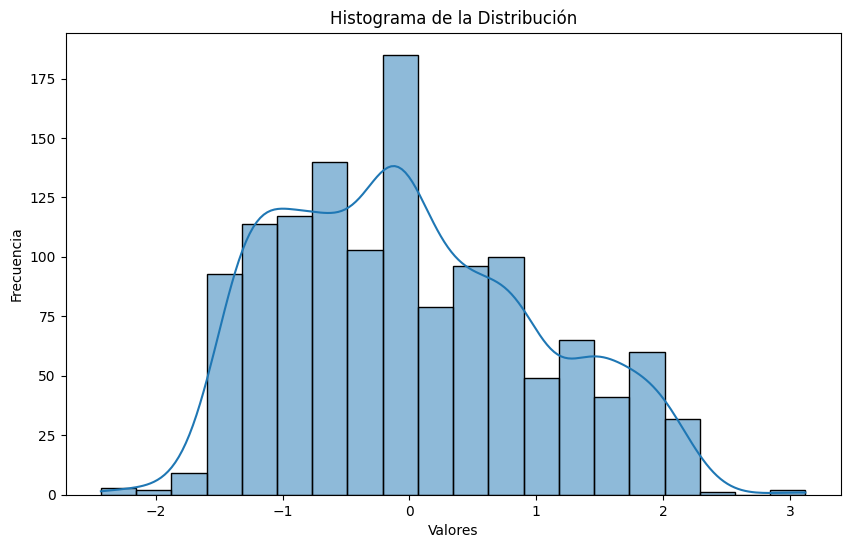

In [103]:
plt.figure(figsize=(10, 6))
sns.histplot(sensores_crudos["angulo_normalized"], bins=20, kde=True)
plt.title('Histograma de la Distribución')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.show()

Se verifica que tras normalizar la data y escalarla, el angulo mantenga su distribución original, a pesar de haber perdido datos.

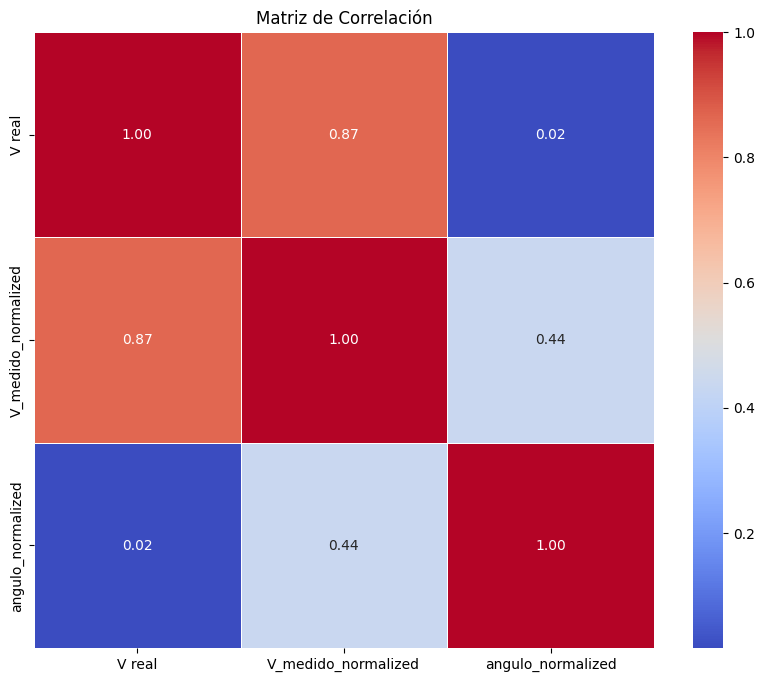

In [114]:
correlation_matrix = sensores_crudos[['V real', 'V_medido_normalized','angulo_normalized']].corr()

# Visualizar la matriz de correlación utilizando un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

Como podemos ver en la matriz de correlación, el angulo no tiene una correlación fuerte con el valor real, pero si tiene una correlación mediana con el valor medido. Un acercamento para estos datos sería usar un modelo de regresión lineal, para explotar la relación lineal del valor medio y el valor real/ el anguo y el valor medido.

# Predicción del Modelo

In [104]:
X = sensores_crudos[['angulo_normalized','V_medido_normalized']]
y = sensores_crudos['V real']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2)

modelo = LinearRegression()

modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [105]:
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.2870009191388728
R^2 Score: 0.9210322581719308


El MSE que se obtuvo fue bastante bajo 0.28 lo cual indica que las predicciones no están tan alejadas del valor esperado. A su vez esto lo podemos confirmar con el R^2 el cual es muy cercano a 1 indicandonos que el modelo se esta ajustando muy bien a los datos.

Es importante destacar que un MSE de 0.28 para un rango de 0 a 9 galones es un poco alto, pero para 1291 datos en los cuales hay 1002 angulos diferentes,es un valor muy bueno ya que la mayoria de angulos solo aparecen 1 vez en el dataset. Esto implica que el modelo esta obteniendo la relación lineal de los datos a pesar de los pocos datos que cuentan.

Text(0.5, 1.0, 'Comparación entre Valores Reales y Predichos')

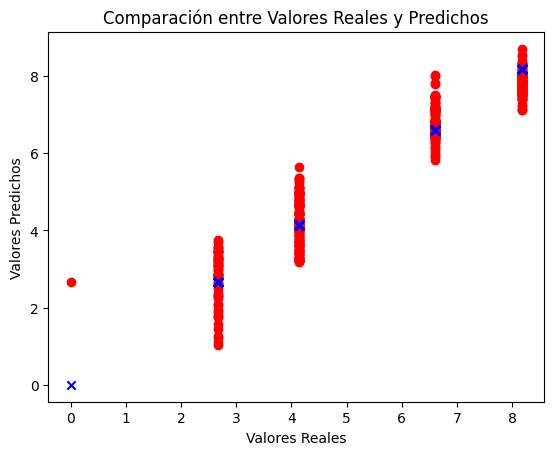

In [107]:
plt.scatter(y_test, y_pred, color='red', label='Predichos')
plt.scatter(y_test, y_test, color='blue', marker='x', label='Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Comparación entre Valores Reales y Predichos')

In [111]:
print("Cantidad de valores reales",sensores_crudos["V real"].unique().shape[0])

Cantidad de valores reales 5


A pesar de tener métricas de desemeño tan buenas podemos ver que al graficar los datos reales vs los predichos, hay muchos datos cercanos al valores real (x) pero agunos se alejan hasta por 2 unidades. Esto puede ser debido a que contamos con una cantidad de datos muy pequeña, y con frecuencia baja. Por lo tanto el modelo no cuenta con suficientes datos para poder predecir con mayor precisión.

También es necesario destacar que solo contamos con 1 valor real de 0, por lo tanto si este valor quedo en el conjunto de datos de prueba, el modelo no podrá predecirlo ya que no cuenta con datos de entrenamiento para este valor. Esto podría explicar porque la predicción para 0 galones es tan mala. A su vez afectando el MSE y el R^2. Por lo tanto estos valores solo confirman el hecho de que es necesario continuar con la medida de datos y/o realizar data augmentation para obtener un mayor número de datos.

Text(0.5, 1.0, 'MSE por Observación')

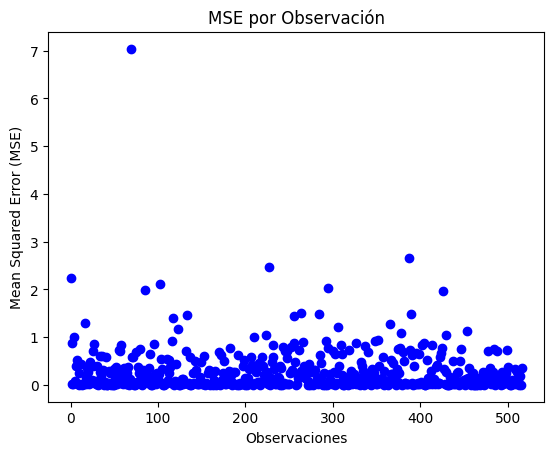

In [112]:
mse_values = np.array([mean_squared_error([y], [yp]) for y, yp in zip(y_test, y_pred)])

# Crear un gráfico de dispersión
plt.scatter(range(len(mse_values)), mse_values, color='blue')

# Etiquetas y título
plt.xlabel('Observaciones')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE por Observación')

Al graficar el mse por cada observación podemos ver que la mayoría de los datos su MSE es muy bajo, pero hay algunos que se alejan mucho del valor real. Al ver esta gráfica y los resultados anteriores puedo concluir que el modelo se adapto bastante bien a los datos, existen ciertas valores los cuales el modelo no pudo predecir pero el acercamiento realizado puede presentar una solución a este problema.

## Recomendaciones

Sería bueno continuar con la toma de datos, ya que con más datos el modelo podría ajustarse mejor a los datos y así poder predecir con mayor precisión. También sería bueno realizar data augmentation, ya que al tener más datos el modelo podría aprender mejor la relación lineal entre los datos. Además sería interesante crear una nueva columna en la que mediante una operación aritmetica se utilizara el valor medio y el angulo para buscar que el angulo tenga una mayor correlación con el valor real. En caso de no lograrlo se podría buscar otro algoritmo ya que el angulo no esta brindando la relación lineal entre los datos que se esperaba. Por último se podría considerar transformar el angulo a grados para ver si esto afecta la correlación con el valor real.